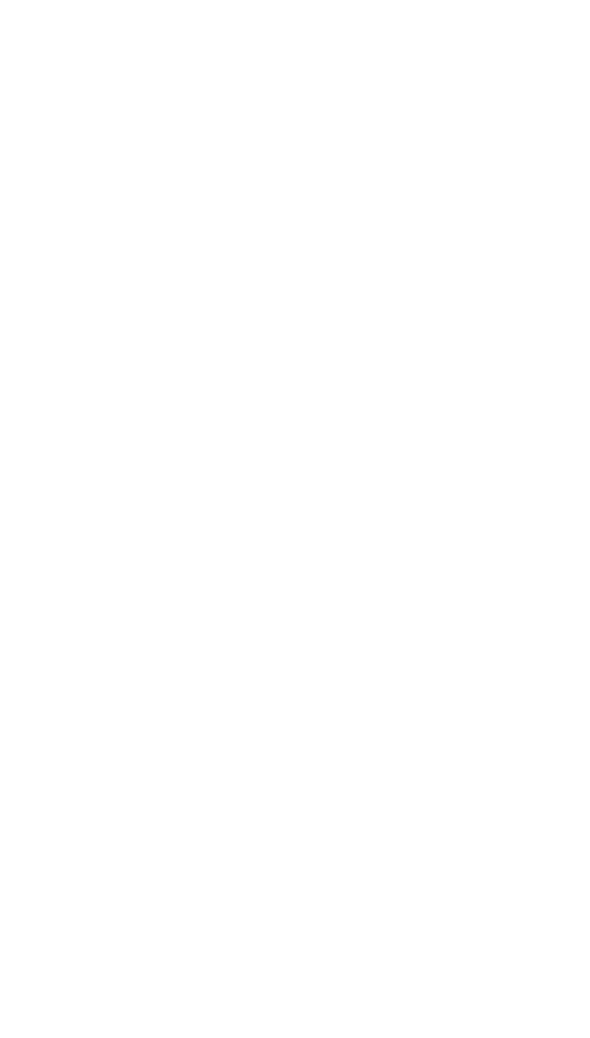

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegWriter
from scipy.interpolate import RegularGridInterpolator

# Load image and get dimensions
image = plt.imread('vangogh.jpg')
ny, nx, _ = image.shape

# Simulation parameters
NUM_PARTICLES = 1_000_000
NUM_FRAMES = 1800
force_scale = 0.1
damping = 0.99

# Precompute interpolators for gradients (smoother and faster than indexing)
x = np.arange(nx)
y = np.arange(ny)
gradients = [np.gradient(image[:, :, i]) for i in range(3)]
interp_grad_x = [RegularGridInterpolator((y, x), g[0], bounds_error=False, fill_value=0) for g in gradients]
interp_grad_y = [RegularGridInterpolator((y, x), g[1], bounds_error=False, fill_value=0) for g in gradients]

# Initialize particles [x, y, vx, vy, channel]
particles = np.zeros((NUM_PARTICLES, 5))
particles[:, 0] = np.random.uniform(0, nx, NUM_PARTICLES)  # x
particles[:, 1] = np.random.uniform(0, ny, NUM_PARTICLES)  # y
particles[:, 2] = np.random.uniform(-1, 1, NUM_PARTICLES)  # vx
particles[:, 3] = np.random.uniform(-1, 1, NUM_PARTICLES)  # vy
particles[:, 4] = np.random.choice([0, 1, 2], NUM_PARTICLES)  # R:0, G:1, B:2

# Vectorized update function
def update_particles(particles):
    particles[:, 0] += particles[:, 2]  # Update positions
    particles[:, 1] += particles[:, 3]
    particles[:, 0] %= nx  # Periodic boundaries
    particles[:, 1] %= ny
    
    # Interpolate gradients at particle positions
    positions = particles[:, [1, 0]]  # [y, x] for interpolation
    channels = particles[:, 4].astype(int)
    grad_x = np.zeros(NUM_PARTICLES)
    grad_y = np.zeros(NUM_PARTICLES)
    for ch in range(3):
        mask = channels == ch
        grad_x[mask] = interp_grad_x[ch](positions[mask])
        grad_y[mask] = interp_grad_y[ch](positions[mask])
    
    # Update velocities
    particles[:, 2] -= grad_x * force_scale
    particles[:, 3] -= grad_y * force_scale
    particles[:, 2] *= damping
    particles[:, 3] *= damping
    return particles

# Set up figure
fig, ax = plt.subplots(figsize=(nx/72, ny/72), dpi=72)
ax.set_xlim(0, nx)
ax.set_ylim(0, ny)
ax.set_aspect('equal')
ax.invert_yaxis()
ax.axis('off')
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)

# Initialize scatter plots
scatters = {
    0: ax.scatter([], [], c='red', s=1/72, alpha=1),
    1: ax.scatter([], [], c='green', s=1/72, alpha=1),
    2: ax.scatter([], [], c='blue', s=1/72, alpha=1)
}


In [ ]:

# Simulate and save frames
for frame in range(NUM_FRAMES):
    # Update all particles at once
    update_particles(particles, gradients, nx, ny)
    
    # Split particles by color for plotting
    positions = {'red': [], 'green': [], 'blue': []}
    for i, ch in enumerate(particles[:, 4].astype(int)):
        color = color_map[ch]
        positions[color].append([particles[i, 0], particles[i, 1]])
    
    # Update scatter plots
    for color in scatters:
        if positions[color]:
            scatters[color].set_offsets(np.array(positions[color]))
    
    # Save frame
    ax.axis("off") 
    plt.savefig(f"images/frame_{frame:03d}.png", dpi=72, bbox_inches='tight', pad_inches=0)

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter, map_coordinates
import os

# Create directory for frames if it doesn’t exist
if not os.path.exists('images'):
    os.makedirs('images')

# Load image and get dimensions
image = plt.imread('vangogh.jpg')
ny, nx, _ = image.shape

# Simulation parameters
NUM_FRAMES = 1800
dt = 0.01  # Smaller time step for stability
nu = 0.05  # Increased viscosity for damping
density_scale = 0.5  # Initial density intensity
force_scale = 0.01  # Reduced force magnitude

# Precompute potential (image intensity) and force (negative gradient)
phi = np.mean(image, axis=2)  # Average RGB to scalar potential
grad_y, grad_x = np.gradient(phi)  # Gradients
force_x = -grad_x * force_scale
force_y = -grad_y * force_scale

# Initialize velocity field (u: x-velocity, v: y-velocity)
u = np.zeros((ny, nx))
v = np.zeros((ny, nx))

# Initialize density fields (R, G, B)
rho_r = np.random.uniform(0, 1, (ny, nx)) * density_scale
rho_g = np.random.uniform(0, 1, (ny, nx)) * density_scale
rho_b = np.random.uniform(0, 1, (ny, nx)) * density_scale

# Helper functions
def advect(field, u, v, dt):
    """Advect a field with reflecting boundaries."""
    y, x = np.indices((ny, nx))
    x_new = x - u * dt
    y_new = y - v * dt
    # Reflect at boundaries
    x_new = np.where(x_new < 0, -x_new, x_new)
    x_new = np.where(x_new >= nx, 2 * (nx - 1) - x_new, x_new)
    y_new = np.where(y_new < 0, -y_new, y_new)
    y_new = np.where(y_new >= ny, 2 * (ny - 1) - y_new, y_new)
    return map_coordinates(field, [y_new, x_new], order=1, mode='nearest')

def diffuse(field, nu, dt):
    """Apply diffusion."""
    return gaussian_filter(field, sigma=np.sqrt(nu * dt))

def project(u, v, dt):
    """Enforce incompressibility with pressure projection."""
    # Compute divergence
    div = (np.roll(u, -1, axis=1) - np.roll(u, 1, axis=1)) / 2 + \
          (np.roll(v, -1, axis=0) - np.roll(v, 1, axis=0)) / 2
    
    # Solve Poisson equation for pressure with FFT
    from scipy.fft import fft2, ifft2
    kx = np.fft.fftfreq(nx) * 2 * np.pi / nx
    ky = np.fft.fftfreq(ny) * 2 * np.pi / ny
    kx, ky = np.meshgrid(kx, ky)
    laplacian = 2 * (np.cos(kx) + np.cos(ky) - 2)
    laplacian[0, 0] = 1  # Avoid division by zero
    p_hat = -fft2(div) / laplacian
    p_hat[0, 0] = 0  # Zero DC component
    p = np.real(ifft2(p_hat))
    
    # Correct velocity field
    u -= (np.roll(p, -1, axis=1) - np.roll(p, 1, axis=1)) / 2
    v -= (np.roll(p, -1, axis=0) - np.roll(p, 1, axis=0)) / 2
    return u, v

# Simulate Navier-Stokes and save frames
for frame in range(NUM_FRAMES):
    # Step 1: Advect velocity field
    u = advect(u, u, v, dt)
    v = advect(v, u, v, dt)
    
    # Step 2: Add external force
    u += force_x * dt
    v += force_y * dt
    
    # Step 3: Diffuse velocity
    u = diffuse(u, nu, dt)
    v = diffuse(v, nu, dt)
    
    # Step 4: Project to enforce incompressibility
    u, v = project(u, v, dt)
    
    # Step 5: Advect density fields
    rho_r = advect(rho_r, u, v, dt)
    rho_g = advect(rho_g, u, v, dt)
    rho_b = advect(rho_b, u, v, dt)
    
    # Step 6: Diffuse densities
    rho_r = diffuse(rho_r, nu * 0.5, dt)
    rho_g = diffuse(rho_g, nu * 0.5, dt)
    rho_b = diffuse(rho_b, nu * 0.5, dt)

    # Create RGB image with shifted densities
    output = np.zeros((ny, nx, 3), dtype=np.float32)
    shift_unit = 1  # Pixel shift
    
    # Red at original position
    output[:, :, 0] = rho_r
    
    # Green shifted right by 1 unit
    output[:, :-shift_unit, 1] = rho_g[:, shift_unit:]
    
    # Blue shifted right by 2 units
    output[:, :-2*shift_unit, 2] = rho_b[:, 2*shift_unit:]
    
    # Clip and normalize for display
    output = np.clip(output, 0, 1)
    
    # Save the frame
    plt.figure(figsize=(nx/72, ny/72), dpi=72)
    plt.imshow(output)
    plt.axis('off')
    plt.subplots_adjust(0, 0, 1, 1)
    plt.savefig(f"images/frame_{frame:03d}.png", dpi=72, bbox_inches='tight', pad_inches=0)
    plt.close()
    
    # Optional: Print max values to check for divergence
    if frame % 100 == 0:
        print(f"Frame {frame}: u_max={np.max(np.abs(u))}, v_max={np.max(np.abs(v))}, rho_max={np.max([rho_r, rho_g, rho_b])}")

print("Simulation complete.")

Frame 0: u_max=3029.450743718665, v_max=4847.237473610217, rho_max=0.4990022363508921


KeyboardInterrupt: 